In [15]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#Explore the training data
csv = pd.read_csv("cleaned_slayer.csv")

In [17]:
csv['file_name'].value_counts()

file_name
0     339
1     338
2     130
3     117
4      88
5      85
6      71
7      45
8      41
9      40
10     38
11     38
12     37
13     37
14     36
15     35
16     35
17     35
18     34
19     31
Name: count, dtype: int64

In [18]:
#Convert training data to list
data_texts = csv['content'].to_list()

data_labels = csv['file_name'].to_list()

In [19]:
#Train Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size = 0.2, random_state = 0 )


train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size = 0.01, random_state = 0 )


In [20]:
#Load up TinyBERT model from huggingface
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.metrics import accuracy_score, precision_score, f1_score


# Load the tokenizer and model for TinyBERT
model_name = 'huawei-noah/TinyBERT_General_4L_312D'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load TinyBERT for Sequence Classification with adjusted num_labels
trainer_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=20
)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "precision": precision,
        "f1": f1
    }
# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Fit Data for PyTorch
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
training_args = TrainingArguments(
    output_dir='./tinybert_results',          
    num_train_epochs=7,       
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    evaluation_strategy="steps",     
    eval_steps=100                   
)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)


# Trainer setup
trainer = Trainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



Step,Training Loss,Validation Loss,Accuracy,Precision,F1
100,No log,2.905087,0.160606,0.025794,0.044450
200,No log,2.700311,0.160606,0.025794,0.044450


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TrainOutput(global_step=287, training_loss=2.8065126000381095, metrics={'train_runtime': 4281.6817, 'train_samples_per_second': 2.135, 'train_steps_per_second': 0.067, 'total_flos': 131245329997824.0, 'train_loss': 2.8065126000381095, 'epoch': 7.0})

In [21]:
#Save Model
trainer.save_model("tinybertfinetune")

In [22]:
#Load media test data
test = pd.read_csv("test.csv")

In [23]:
# Convert country to country integer values
test['country'] = pd.to_numeric(test['country'], errors='coerce')

# Drop rows with NaN values
test = test.dropna(subset=['country'])



In [24]:
test['country'].value_counts()

country
1.0     517
0.0     114
3.0      34
2.0      13
10.0      1
4.0       1
Name: count, dtype: int64

In [25]:
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()

In [26]:
from transformers import DistilBertTokenizer

# Load the tokenizer used during training

model_name = 'huawei-noah/TinyBERT_General_4L_312D'


tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


In [27]:
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch dataset for test set
test_dataset = TextDataset(test_encodings, test_labels)


In [28]:
test_results = trainer.predict(test_dataset)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [29]:
metrics = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")


Test Accuracy: 0.7602941176470588
Test F1: 0.6567620030468327
Test Precision: 0.5780471453287197


In [30]:
#Convert from integers back to country codes
country_codes = ['GB', 'US', 'AU', 'CA', 'IE', 'PH']
number_to_country_code = {index: country for index, country in enumerate(country_codes)}


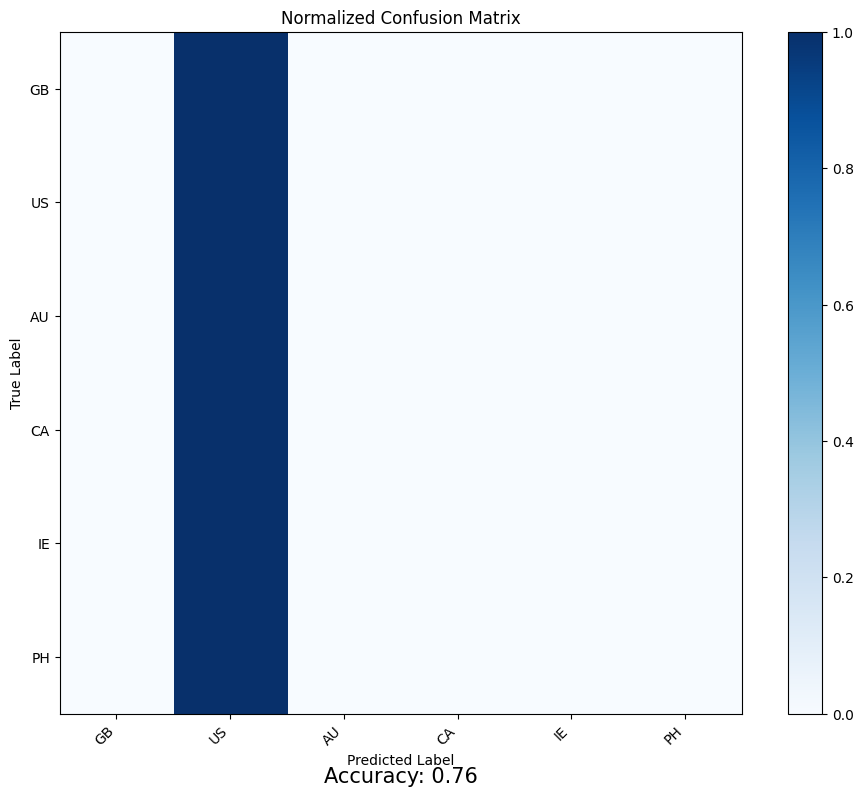

In [31]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np3
#Generate a confusion matrix
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')


class_names = [number_to_country_code[i] for i in range(len(country_codes))]

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()


tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)


accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)


plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()



In [32]:
#Read/Clean COVID dataset
test = pd.read_csv("testcovid.csv")
# Convert to numeric with errors='coerce' (turns invalid values into NaN)
test['country'] = pd.to_numeric(test['country'], errors='coerce')

# Drop rows with NaN values (those that couldn't be converted)
test = test.dropna(subset=['country'])
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()

In [33]:

from transformers import DistilBertTokenizer

# Load the tokenizer used during training
model_name = 'huawei-noah/TinyBERT_General_4L_312D'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate dataset
test_dataset = TextDataset(test_encodings, test_labels)


In [34]:
test_results = trainer.predict(test_dataset)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [35]:
metrics = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")

Test Accuracy: 0.41798298906439857
Test F1: 0.24642013408423838
Test Precision: 0.17470977914720912


In [36]:

country_codes = ['gb', 'us', 'au', 'ca', 'ie', 'in', 'nz', 'pk', 'lk', 'za', 'ph', 'sg', 'my', 'ng', 'ke', 'bd', 'hk', 'jm', 'gh', 'tz']

number_to_country_code = {index: country for index, country in enumerate(country_codes)}

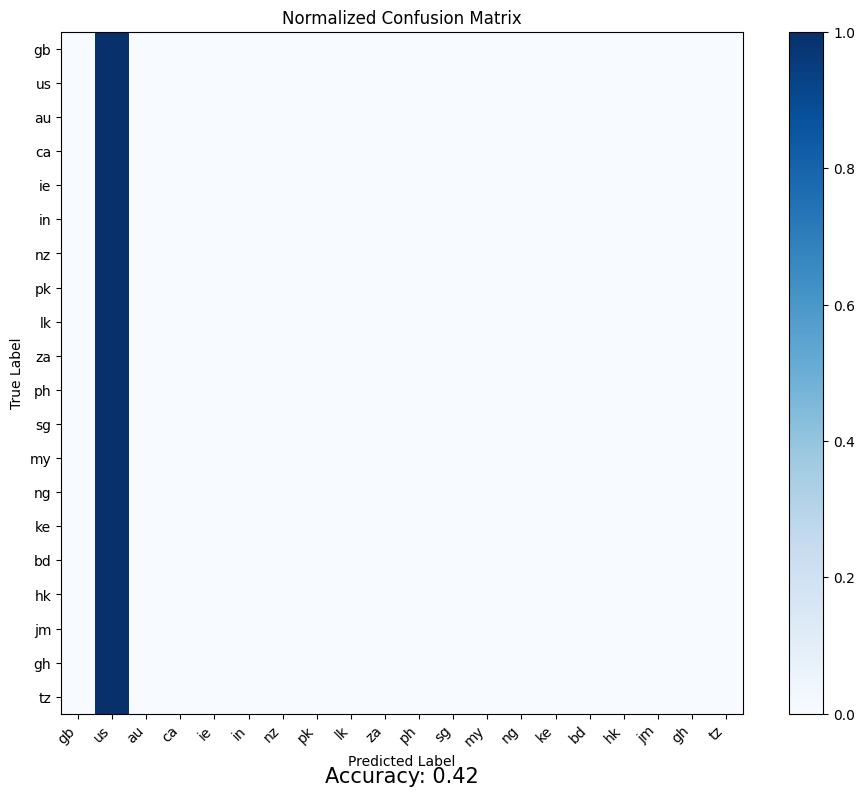

In [39]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Get the predicted labels and true labels
predictions = test_results.predictions.argmax(axis=-1)  # Choose the class with highest probability
true_labels = test_results.label_ids

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

# Get class names from your label encoder or dataset
# If you have a label encoder, use it to get the class names:
class_names = [number_to_country_code[i] for i in range(len(country_codes))]

# Create a confusion matrix plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add labels for axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Display overall accuracy
accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

In [40]:
#Clean and load NOW test dataset
test = pd.read_csv("testnow.csv")
test['country'] = pd.to_numeric(test['country'], errors='coerce')

test = test.dropna(subset=['country'])
test_texts = test['text'].to_list()

test_labels = test['country'].to_list()

In [41]:

from transformers import DistilBertTokenizer

model_name = 'huawei-noah/TinyBERT_General_4L_312D'

tokenizer = AutoTokenizer.from_pretrained(model_name)


test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)
class NewTestDataset(Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

test_dataset = TextDataset(test_encodings, test_labels)

In [42]:
test_results = trainer.predict(test_dataset)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
metrics = test_results.metrics
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1: {metrics['test_f1']}")
print(f"Test Precision: {metrics['test_precision']}")

Test Accuracy: 0.1337290502793296
Test F1: 0.03154802972404265
Test Precision: 0.017883458888611464


In [44]:

country_codes = ['gb', 'us', 'au', 'ca', 'ie', 'in', 'nz', 'pk', 'lk', 'za', 'ph', 'sg', 'my', 'ng', 'ke', 'bd', 'hk', 'jm', 'gh', 'tz']

number_to_country_code = {index: country for index, country in enumerate(country_codes)}

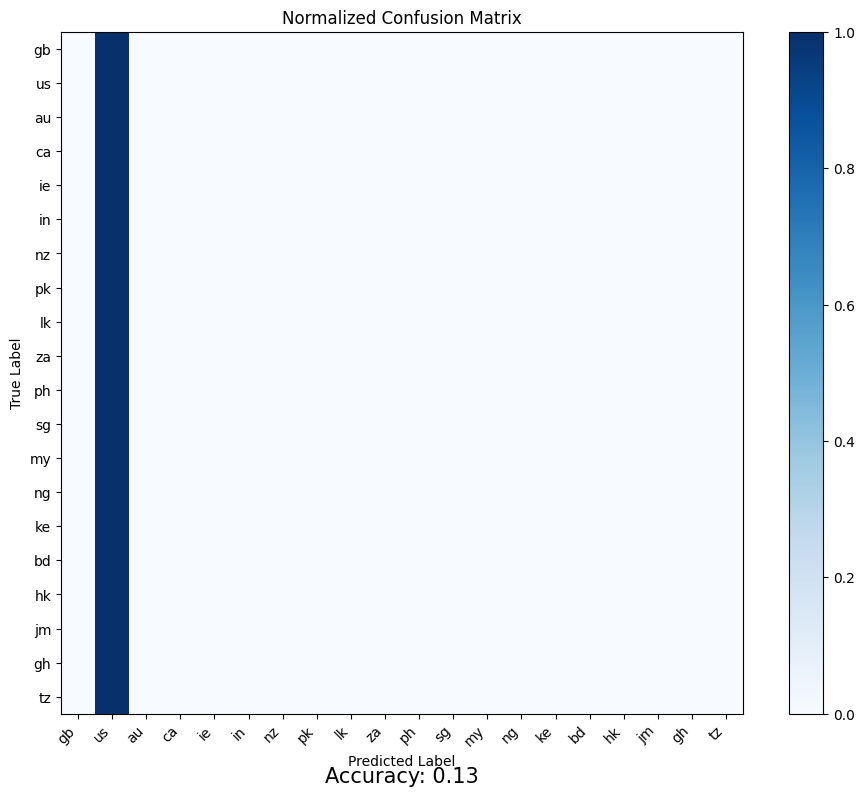

In [45]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

predictions = test_results.predictions.argmax(axis=-1)
true_labels = test_results.label_ids

cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')


class_names = [number_to_country_code[i] for i in range(len(country_codes))]

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

accuracy = (predictions == true_labels).mean()
plt.text(0.5, -0.1, f'Accuracy: {accuracy:.2f}', size=15, ha='center', transform=plt.gca().transAxes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()